In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm

## Relative imports
import astroddpm
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.separation import double_loader, method1_algo2, check_separation1score, separation1score, load_everything
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
from astroddpm.utils import colormap_custom

from astroddpm.analysis.validationMetrics.powerSpectrum import compare_separation_power_spectrum_iso
import astroddpm.analysis.validationMetrics.powerSpectrum as powerspectrum


import bm3d
from bm3d import bm3d, BM3DStages

In [2]:
MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32_firstc_20_invsqrt'

In [3]:
amin,amax=(-3, 3)
bins = np.linspace(0, np.pi, 100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
## Method 1
diffuser = load_everything(MODEL_ID)

## Method 2
# diffuser = Diffuser(DiscreteSBM(DiscreteVPSDE(1000),ResUNet()))
# config = config_from_id(MODEL_ID)
# diffuser2.load(config = config, also_ckpt=True)

No model id found
Looking for the diffuser corresponding to model_id DiscreteSBM_MultiSigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32_firstc_20_invsqrt in the MODELS.json all config file
Loading the diffuser from a config dict.
Loading only the weights, no optimizer or scheduler.


## One score source separation/denoising with gaussian fields (from standard gaussian to CMB gaussian random field)

In [5]:
t = 100

NUM_MAX_SAMPLES = 64
NUM_SAMPLES = 32

noise_strength = diffuser.diffmodel.sde.noise_level(t).item()
noise_strength

0.3436066210269928

In [6]:
truth_list, noisy_list, denoised_list = check_separation1score(diffuser, None, t, 1, NUM_SAMPLES, False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 22.15it/s]


AttributeError: 'tuple' object has no attribute 'split'

In [7]:
denoised_list[0].shape

torch.Size([256, 1, 256, 256])

/tmp/ipykernel_846415/3748555510.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.01, hspace=0.01)


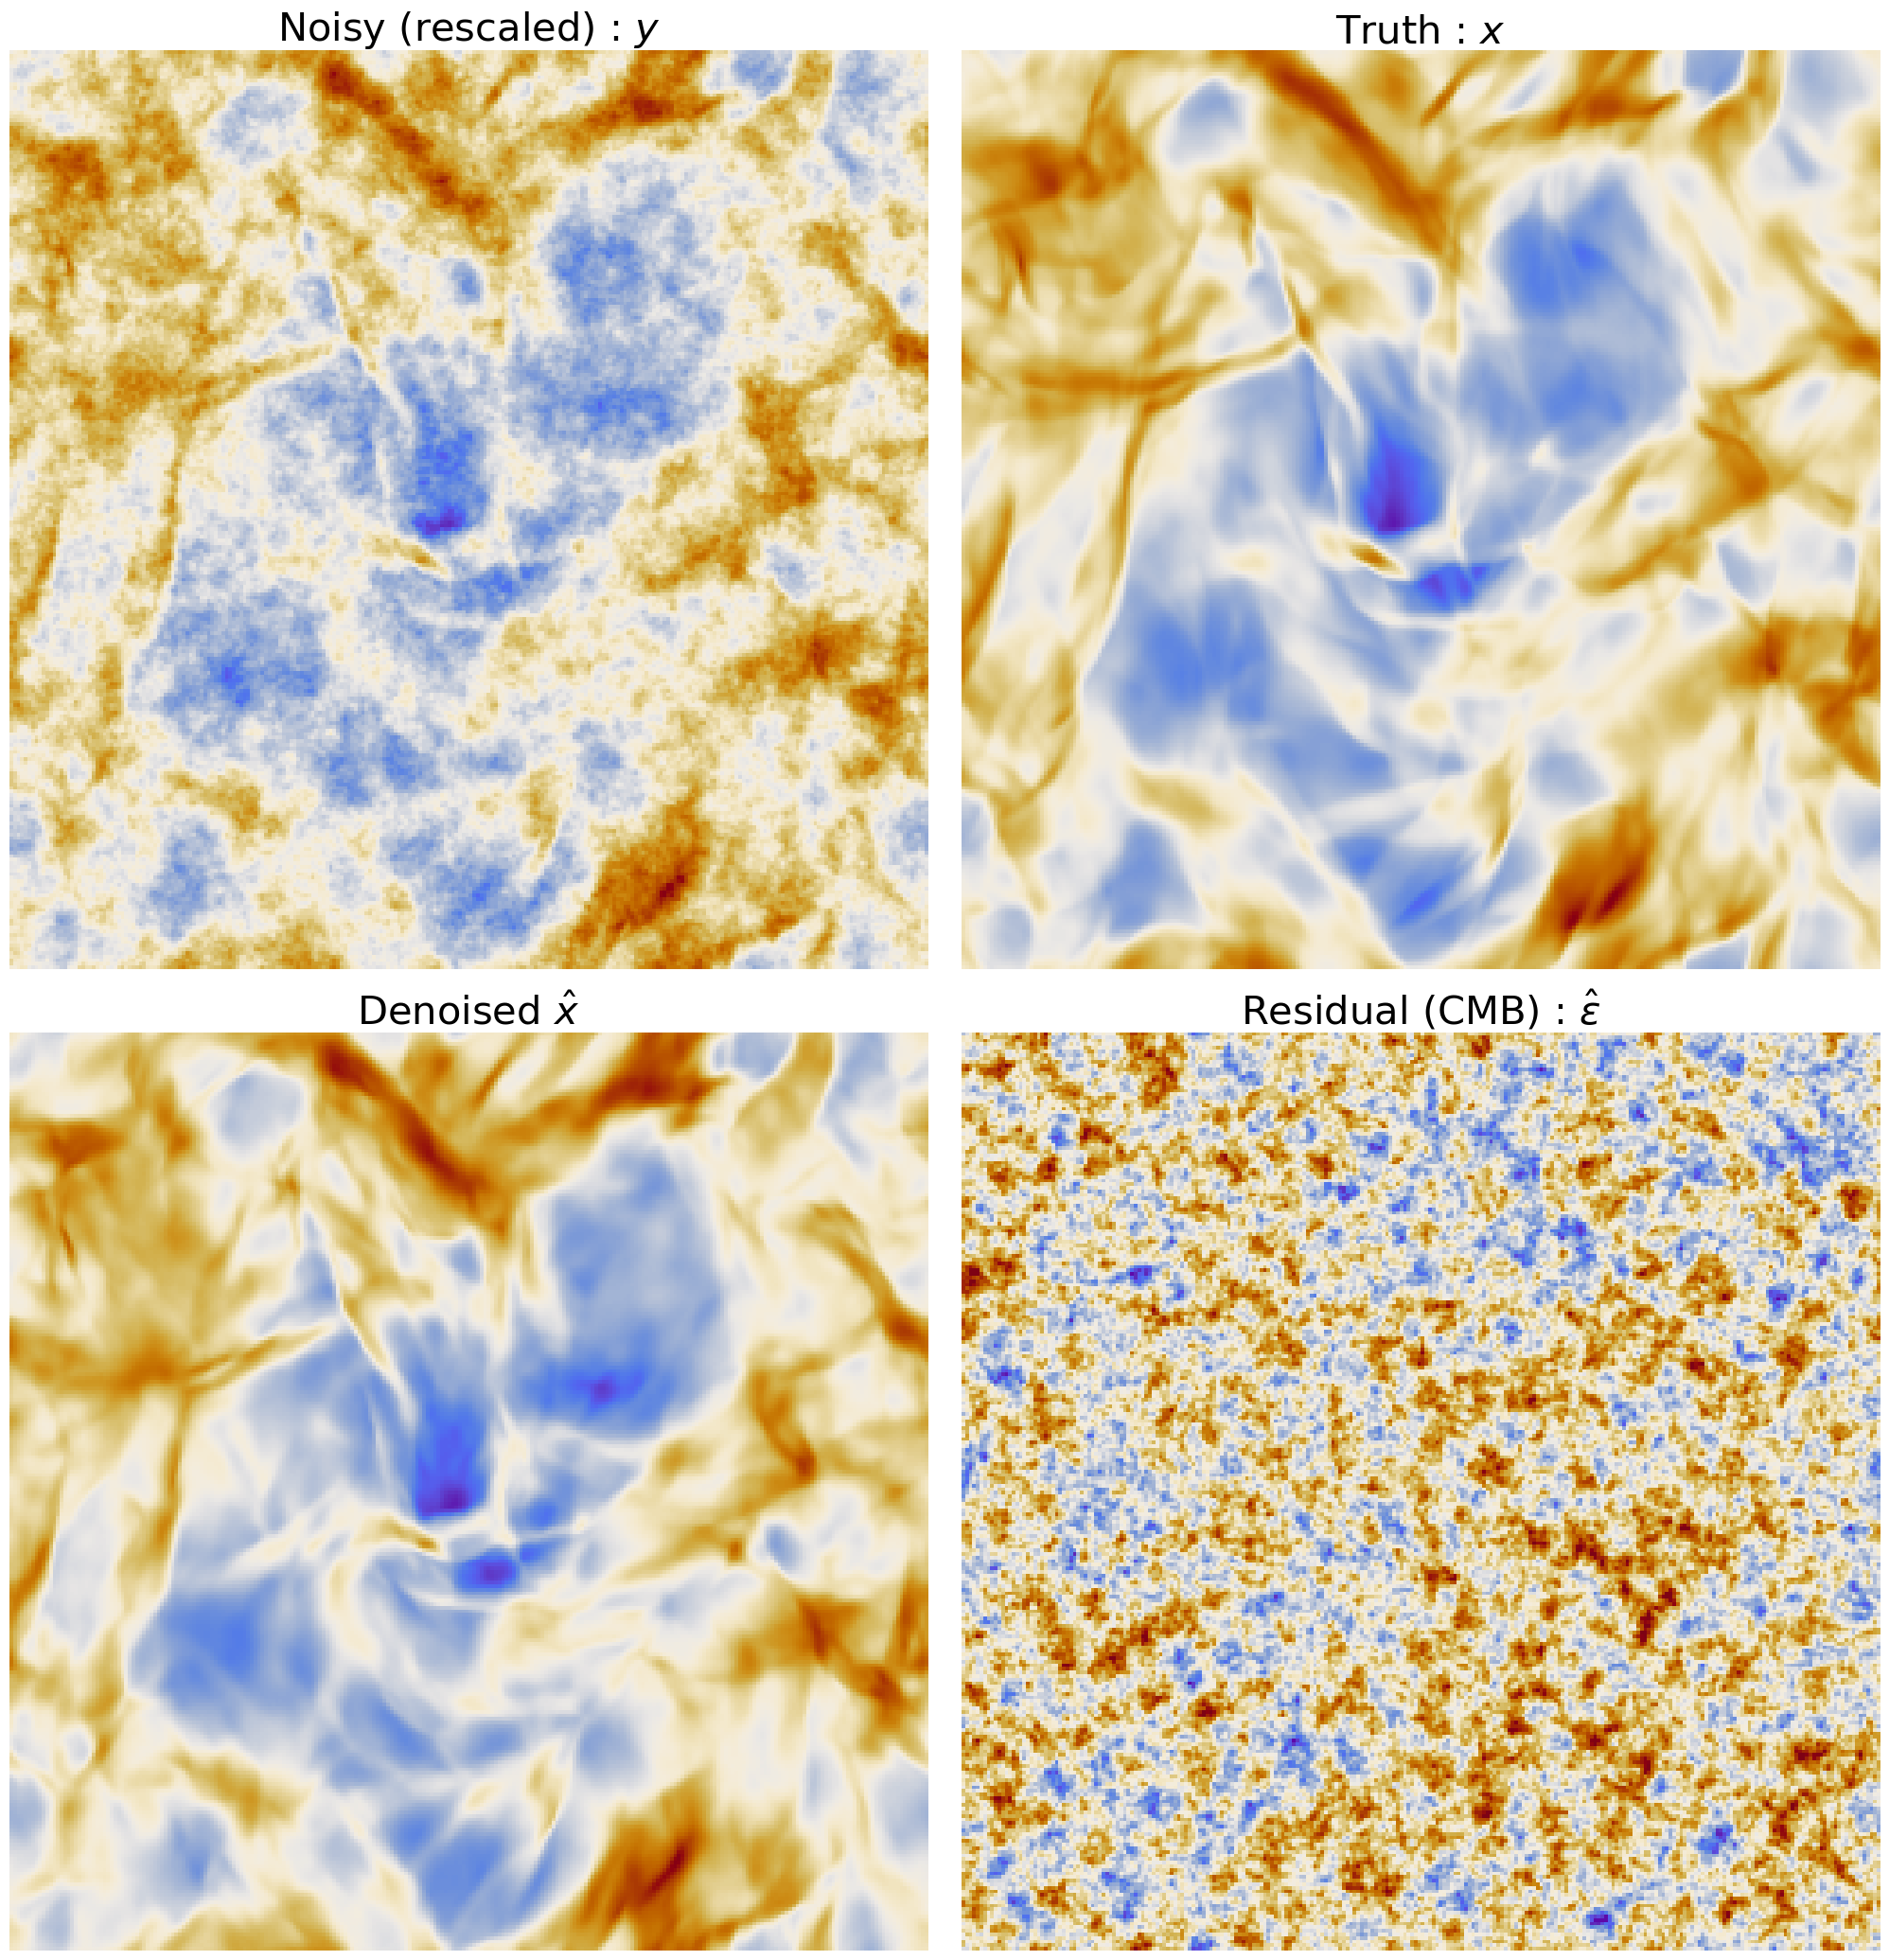

In [32]:
amin, amax = -3, 3
fig, ax= plt.subplots(2,2,figsize=(20,20.6),layout = 'constrained' )
ax[0,1].imshow(truth_list[0][0][0],vmin=amin, vmax=amax, cmap = 'cmb')
ax[0,1].set_title('Truth : $x$', fontsize = 30)
ax[0,1].axis('off')
ax[1,0].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin, vmax=amax,cmap = 'cmb')
ax[1,0].set_title('Denoised $\hat x$', fontsize = 30)
ax[1,0].axis('off')
ax[1,1].imshow((noisy_list[0][0][0].detach().cpu()-denoised_list[0][0][0].detach().cpu())/noise_strength,vmin=amin, vmax=amax,cmap = 'cmb')
ax[1,1].set_title('Residual (CMB) : $\hat\epsilon$', fontsize = 30)
ax[1,1].axis('off')
ax[0,0].imshow(noisy_list[0][0][0].detach().cpu(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax,cmap = 'cmb')
ax[0,0].set_title('Noisy (rescaled) : $y$', fontsize = 30)
ax[0,0].axis('off')
## Set the distance between the plots to 0
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(astroddpm.__file__)),'images','Separation_CMB_line.pdf'))

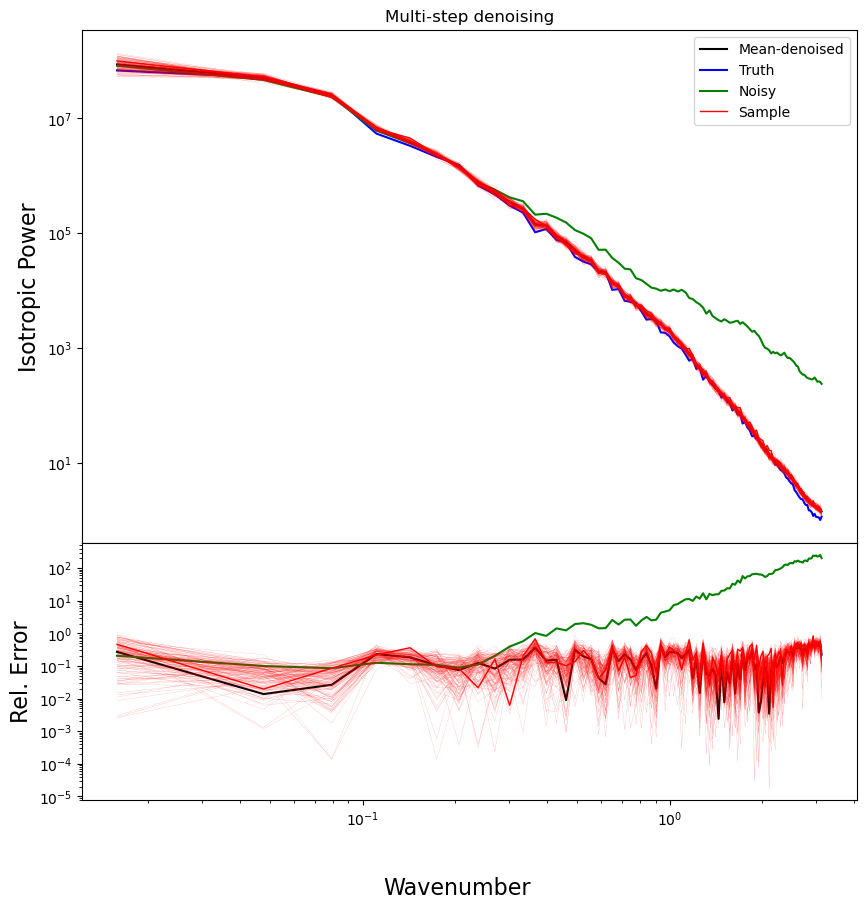

In [44]:
b0_0, b3_0, mean_0, std_0, bins = compare_separation_power_spectrum_iso(target_image.to(device),samples, noisy = input_batch[:1], only_trajectories= True, title= 'Multi-step denoising', relative_error= True, elementary_figsize=(10,10))

In [45]:
true_cmb = input_batch[:1]-target_image.to(device)
true_cmb.shape

torch.Size([1, 1, 256, 256])

In [46]:
estimated_cmb = (input_batch-samples)/noise_strength
estimated_cmb.shape

torch.Size([128, 1, 256, 256])

In [47]:
true_ps = diffuser.diffmodel.ps(theta_target)

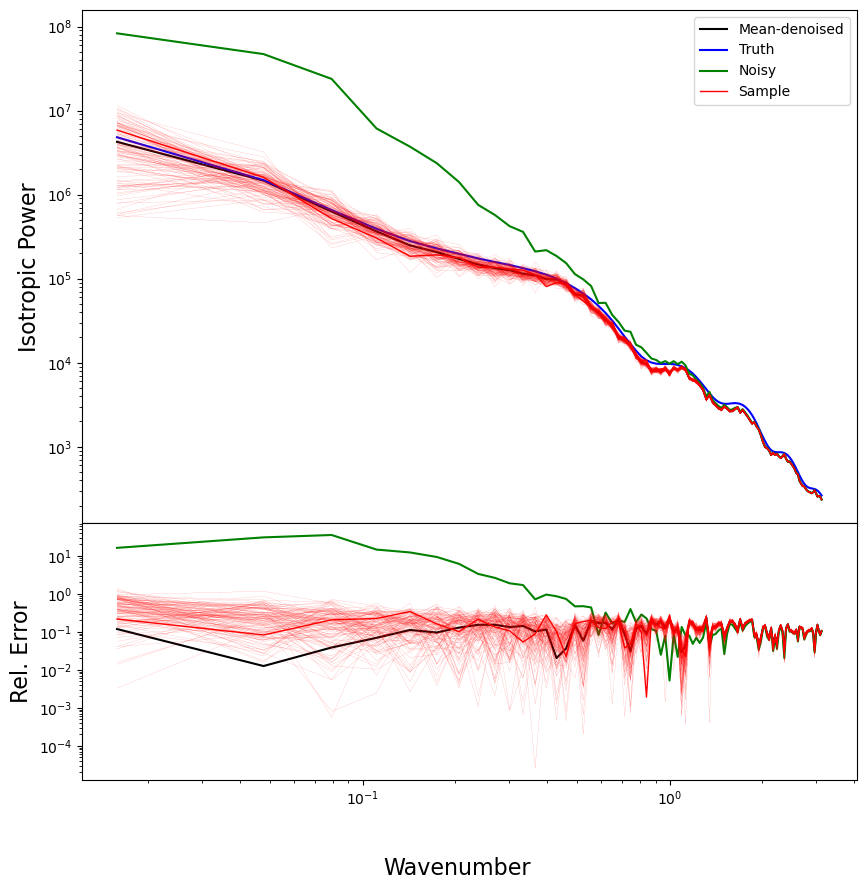

In [48]:
b0_1, b3_1, mean_1, std_1, bins = compare_separation_power_spectrum_iso(true_cmb[:1],estimated_cmb*noise_strength, noisy = input_batch[:1], only_trajectories= True, title= None, relative_error= True, elementary_figsize=(10,10), true_ps=256**2*noise_strength**2*true_ps.to(device))

In [47]:
bins_centers = (bins[:-1] + bins[1:])/2
fontsize = 20

## Error for 0
rel_err_0 = torch.abs((power_spectra_0 - b0_0)/b0_0)

bias_0 = torch.abs((mean_0 - b0_0)/b0_0)

noisy_rel_err_0 = torch.abs((b3_0 - b0_0)/b0_0)

## Same for 1 
rel_err_1 = torch.abs((power_spectra_1 - b0_1)/b0_1)

bias_1 = torch.abs((mean_1 - b0_1)/b0_1)

noisy_rel_err_1 = torch.abs((b3_1 - b0_1)/b0_1)

fig, axs = plt.subplots(2, 2, figsize = (20,13), height_ratios=[2,1],sharex=True, layout = 'constrained')
fig.subplots_adjust(hspace=0, wspace=0.1)
fig.supxlabel('Wavenumber [$2\pi\cdot\mathrm{px}^{-1}$]', fontsize=fontsize)
axs[0,0].plot(bins_centers.cpu(), mean_0[:-1].cpu(), '-k', label = 'Mean-denoised')
axs[0,0].plot(bins_centers.cpu(), b0_0[:-1].cpu(), 'b', label = 'Truth')
axs[0,0].plot(bins_centers.cpu(), b3_0[:-1].cpu(), 'g', label = 'Noisy')
idx = np.random.randint(len(power_spectra_0))
for i, ps in enumerate(power_spectra_0):
    if i==idx:
        linewidth = 1 
        axs[0,0].plot(bins_centers.cpu(), ps[:-1].cpu(), 'r', linewidth=linewidth,label = 'Sample')
    else:
        linewidth = 1/(np.sqrt(NUM_SAMPLES)*np.sqrt(2))
        axs[0,0].plot(bins_centers.cpu(), ps[:-1].cpu(), 'r', linewidth=linewidth)
axs[0,0].legend(prop={'size': fontsize})
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel('Power Spectrum', fontsize=fontsize)

axs[1,0].plot(bins_centers.cpu(), bias_0[:-1].cpu(), '-k', label = 'PS estimator relative bias') ##Relative error of the mean of PS
axs[1,0].plot(bins_centers.cpu(), noisy_rel_err_0[:-1].cpu(), '-g', label = 'Noisy relative error')
for i, rel in enumerate(rel_err_0):
    if i==idx:
        linewidth = 1 
        axs[1,0].plot(bins_centers.cpu(), rel[:-1].cpu(), 'r', linewidth=linewidth)
    else:
        linewidth = 1/(np.sqrt(NUM_SAMPLES)*np.sqrt(2))
        axs[1,0].plot(bins_centers.cpu(), rel[:-1].cpu(),'r', linewidth=linewidth)
#axs[1,0].legend()
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel('Rel. Error', fontsize=fontsize)

title = 'Power spectrum estimation for dust'
axs[0,0].set_title(title, fontsize=fontsize)

axs[0,1].plot(bins_centers.cpu(), mean_1[:-1].cpu(), '-k', label = 'Mean-denoised')
axs[0,1].plot(bins_centers.cpu(), b0_1[:-1].cpu(), 'b', label = 'Truth')
axs[0,1].plot(bins_centers.cpu(), b3_1[:-1].cpu(), 'g', label = 'Noisy')
idx = np.random.randint(len(power_spectra_1))
for i, ps in enumerate(power_spectra_1):
    if i==idx:
        linewidth = 1 
        axs[0,1].plot(bins_centers.cpu(), ps[:-1].cpu(), 'r', linewidth=linewidth,label = 'Sample')
    else:
        linewidth = 1/(np.sqrt(NUM_SAMPLES)*np.sqrt(2))
        axs[0,1].plot(bins_centers.cpu(), ps[:-1].cpu(), 'r', linewidth=linewidth)
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

axs[1,1].plot(bins_centers.cpu(), bias_1[:-1].cpu(), '-k', label = 'PS estimator relative bias') ##Relative error of the mean of PS
axs[1,1].plot(bins_centers.cpu(), noisy_rel_err_1[:-1].cpu(), '-g', label = 'Noisy relative error')
for i, rel in enumerate(rel_err_1):
    if i==idx:
        linewidth = 1 
        axs[1,1].plot(bins_centers.cpu(), rel[:-1].cpu(), 'r', linewidth=linewidth)
    else:
        linewidth = 1/(np.sqrt(NUM_SAMPLES)*np.sqrt(2))
        axs[1,1].plot(bins_centers.cpu(), rel[:-1].cpu(),'r', linewidth=linewidth)
#axs[1,1].legend()
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

title = 'Power spectrum estimation for the CMB'
axs[0,1].set_title(title, fontsize=fontsize)

NameError: name 'power_spectra_0' is not defined

/tmp/ipykernel_187251/25691685.py:12: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0.1)


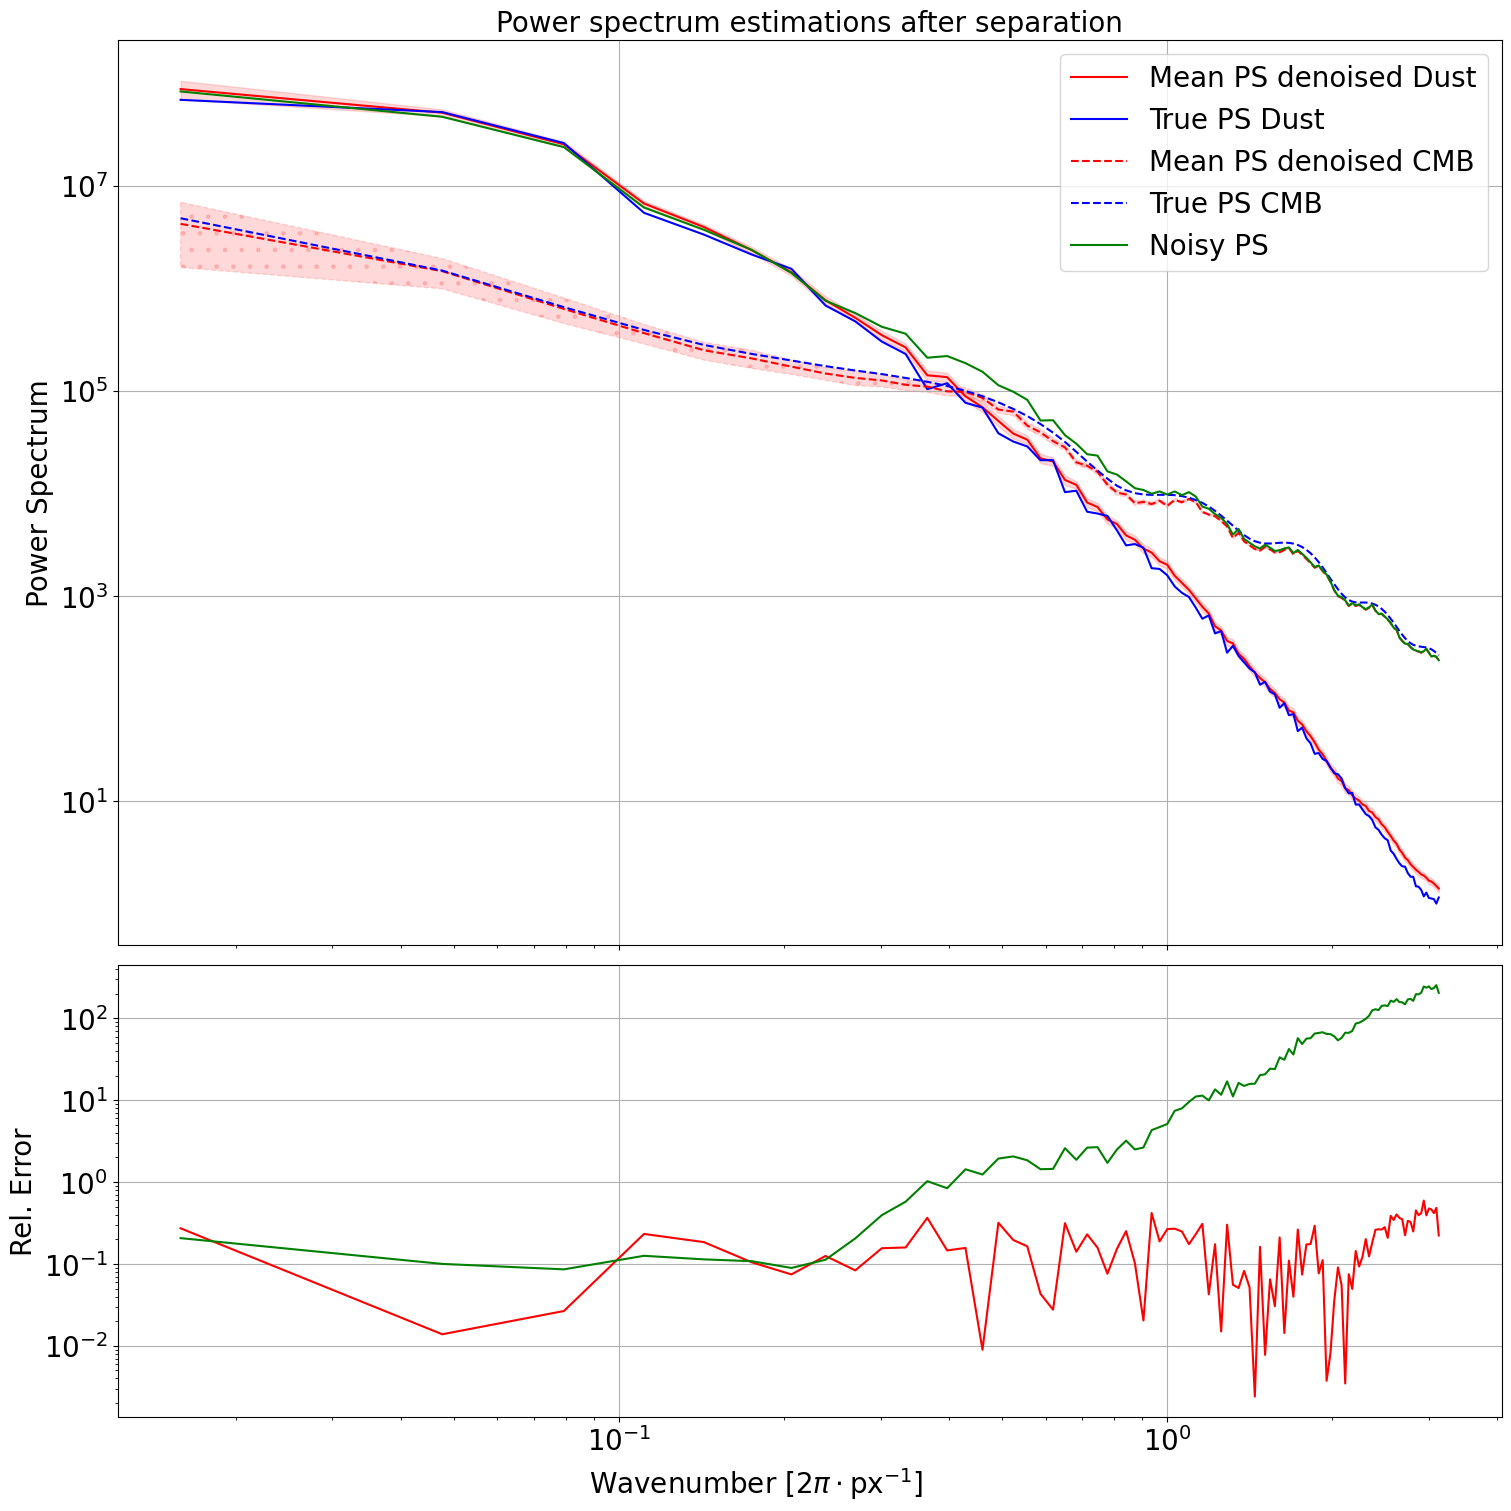

In [49]:
bins_centers = (bins[:-1] + bins[1:])/2
fontsize = 20
grid = True

## Error for 0

bias_0 = torch.abs((mean_0 - b0_0)/b0_0)

noisy_rel_err_0 = torch.abs((b3_0 - b0_0)/b0_0)

fig, axs = plt.subplots(2, figsize = (15,15), height_ratios=[2,1],sharex=True, layout = 'constrained')
fig.subplots_adjust(hspace=0, wspace=0.1)
fig.supxlabel('Wavenumber [$2\pi\cdot\mathrm{px}^{-1}$]', fontsize=fontsize)
axs[0].plot(bins_centers.cpu(), mean_0[:-1].cpu(), 'r', label = 'Mean PS denoised Dust')
axs[0].fill_between(bins_centers.cpu(), mean_0[:-1].cpu() - std_0[:-1].cpu(), mean_0[:-1].cpu() + std_0[:-1].cpu(), alpha = 0.15, color = 'r')
axs[0].plot(bins_centers.cpu(), b0_0[:-1].cpu(), 'b', label = 'True PS Dust')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('Power Spectrum', fontsize=fontsize)

axs[1].plot(bins_centers.cpu(), bias_0[:-1].cpu(), 'r', label = 'PS estimator relative bias') ##Relative error of the mean of PS
axs[1].plot(bins_centers.cpu(), noisy_rel_err_0[:-1].cpu(), '-g', label = 'Noisy relative error')

#axs[1,0].legend()
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel('Rel. Error', fontsize=fontsize)



title = 'Power spectrum estimations after separation'
axs[0].set_title(title, fontsize=fontsize)

axs[0].plot(bins_centers.cpu(), mean_1[:-1].cpu(), '--r', label = 'Mean PS denoised CMB')
axs[0].fill_between(bins_centers.cpu(), mean_1[:-1].cpu() - std_1[:-1].cpu(), mean_1[:-1].cpu() + std_1[:-1].cpu(), alpha = 0.15, color = 'r' , hatch = '.', linestyle = 'dashed')
axs[0].plot(bins_centers.cpu(), b0_1[:-1].cpu(), '--b', label = 'True PS CMB')
axs[0].plot(bins_centers.cpu(), b3_0[:-1].cpu(), 'g', label = 'Noisy PS')

axs[0].legend(prop={'size': fontsize})
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(grid)
axs[1].grid(grid)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)

if grid:
    plt.savefig(os.path.join(os.path.dirname(os.path.dirname(astroddpm.__file__)),'images','Separation_PS_estimation_grid_avg.pdf'))
else:
    plt.savefig(os.path.join(os.path.dirname(os.path.dirname(astroddpm.__file__)),'images','Separation_PS_estimation_avg.pdf'))

In [52]:
rthetas[0], rtheta_target

(tensor([ 0.7061, -0.7142], device='cuda:0'),
 tensor([[ 0.7061, -0.7142]], device='cuda:0'))

Check tweedie (one step denoising)

In [10]:
truth_list, noisy_list, denoised_list = check_separation1score(diffuser, None, t, 1, NUM_SAMPLES, True)

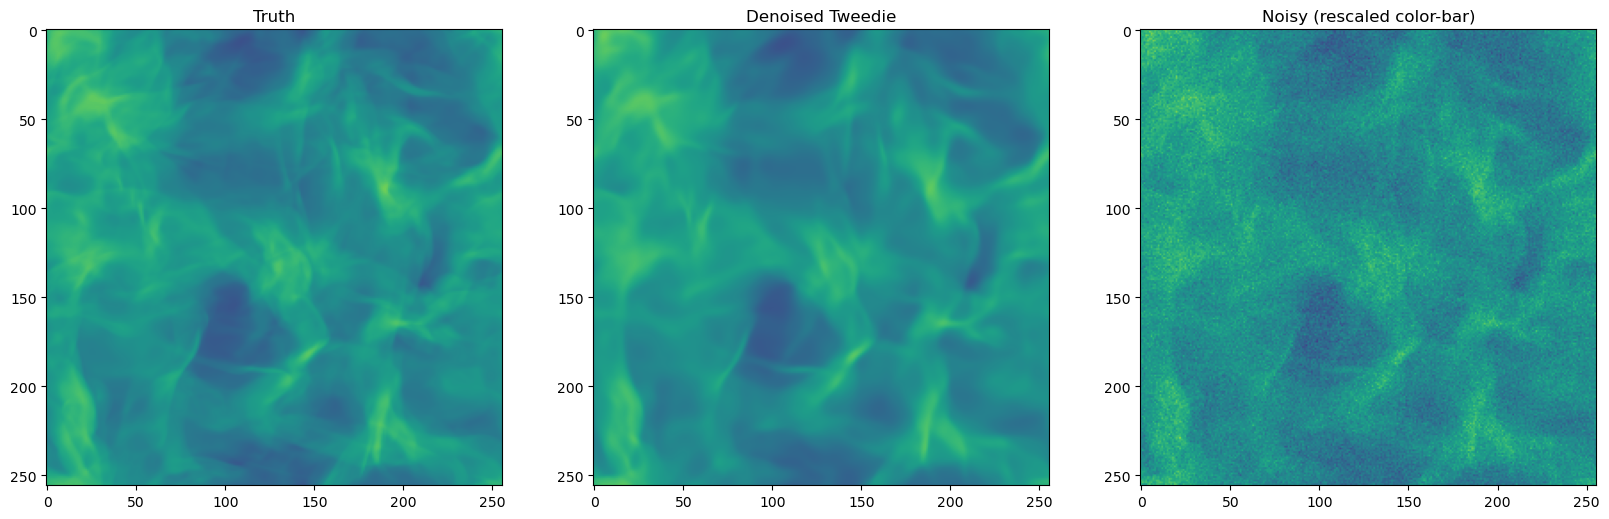

In [11]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth_list[0][0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised Tweedie')
ax[2].imshow(noisy_list[0][0][0].detach().cpu(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

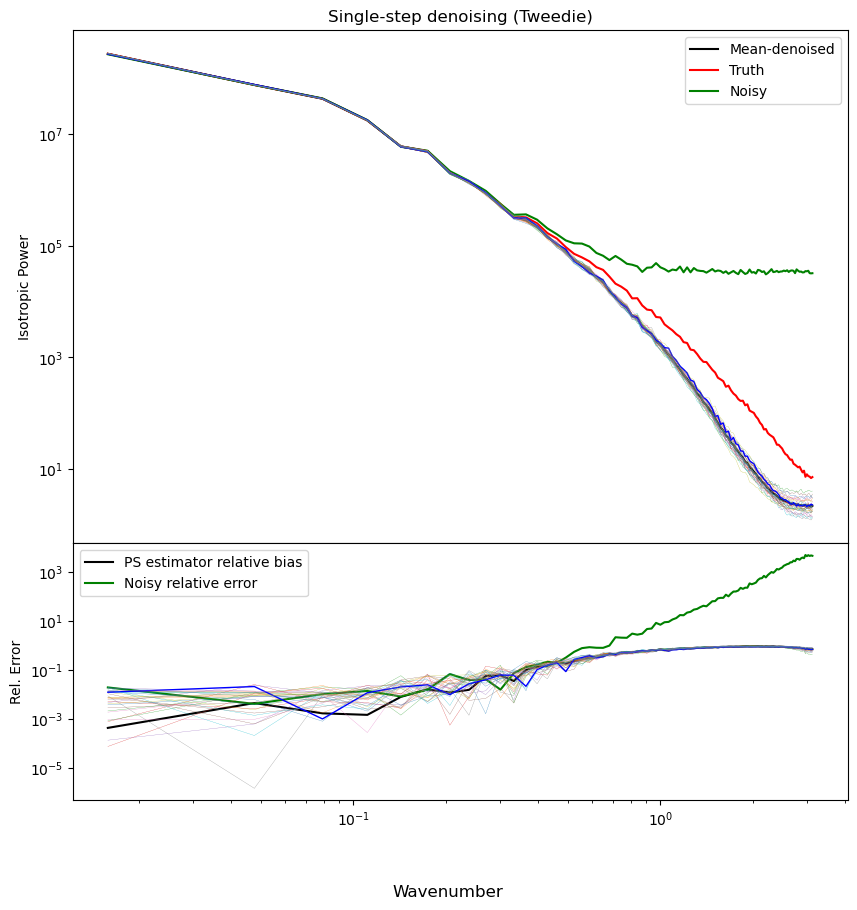

In [12]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth_list[0],denoised_list[0], noisy = noisy_list[0], only_trajectories= True, title = 'Single-step denoising (Tweedie)', elementary_figsize=(10,10), relative_error= True)

### BM3D

/tmp/ipykernel_548322/3633244086.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  img = ax.imshow(signed_relative_error_bm3d, aspect='auto', origin='lower', extent=[0, np.pi, 0.2, 9], vmin = -1, vmax = 1, cmap = 'bwr')


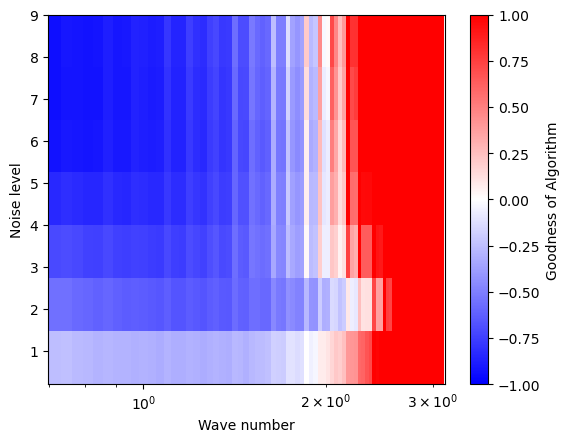

In [30]:
num_to_denoise = 1

In [31]:
testbatch1 = next(iter(diffuser.test_dataloader))
truth = testbatch1[:num_to_denoise].to(device)

if truth.ndim == 3:
    truth = truth.unsqueeze(1)

In [80]:
t = 100

In [81]:
timesteps=torch.full((truth.shape[0],), t).long().to(device)
noise_strength = diffuser.diffmodel.sde.noise_level(timesteps).reshape(-1).cpu().item()
noise_strength

0.12815001606941223

In [82]:
observation , _ , _= diffuser.diffmodel.sde.sampling(truth, timesteps)
#observation = model1.sqrt_alphas_cumprod[noise_step]*truth + model1.sqrt_one_minus_alphas_cumprod[noise_step]*noise
observation = diffuser.diffmodel.sde.rescale_preserved_to_additive(observation, timesteps)
observation.shape

torch.Size([1, 1, 256, 256])

In [83]:
if isinstance(diffuser.diffmodel.sde, DiscreteVPSDE):
    power_spectrum = noise_strength
else:
    power_spectrum = diffuser.diffmodel.sde.power_spectrum.detach.cpu().numpy()
    power_spectrum *= noise_strength * power_spectrum.size

In [84]:
denoised_bm3d = bm3d(observation[0][0].cpu().detach().numpy(), sigma_psd = power_spectrum, stage_arg=BM3DStages.HARD_THRESHOLDING, )#stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING profile = 'refilter'

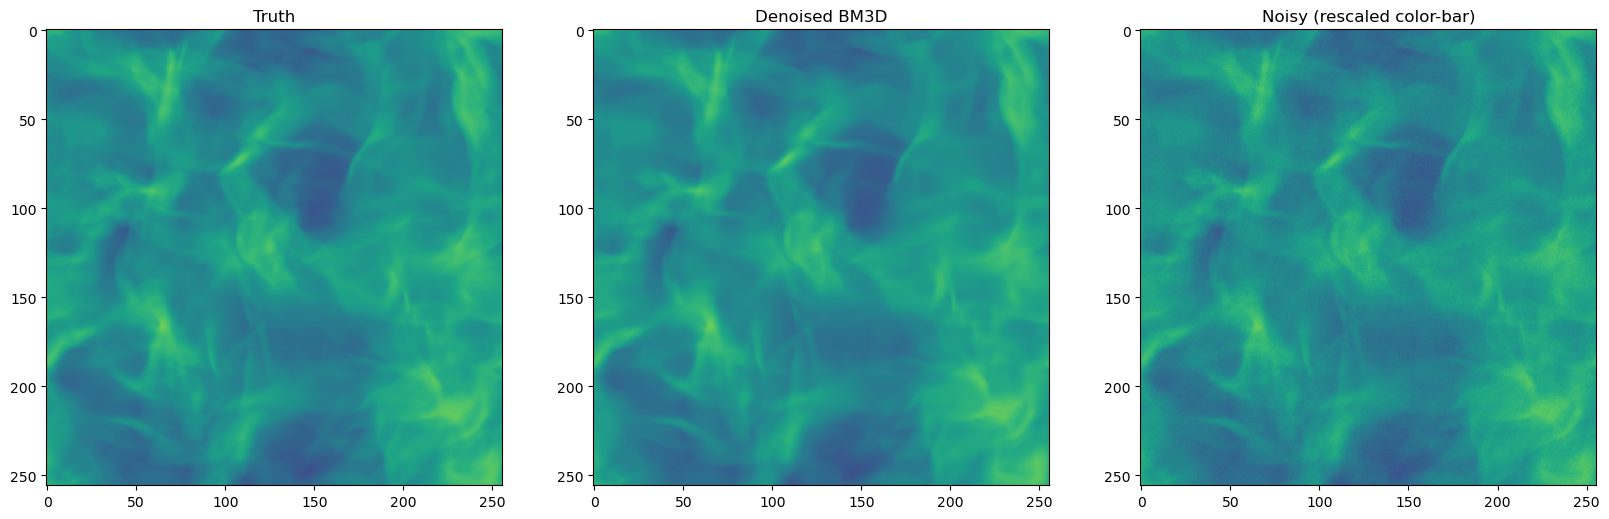

In [85]:
## Plot the truth, the bm3d_denoised image and the observation
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth[0][0].cpu().detach().numpy(),vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_bm3d,vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised BM3D')
ax[2].imshow(observation[0][0].cpu().detach().numpy(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

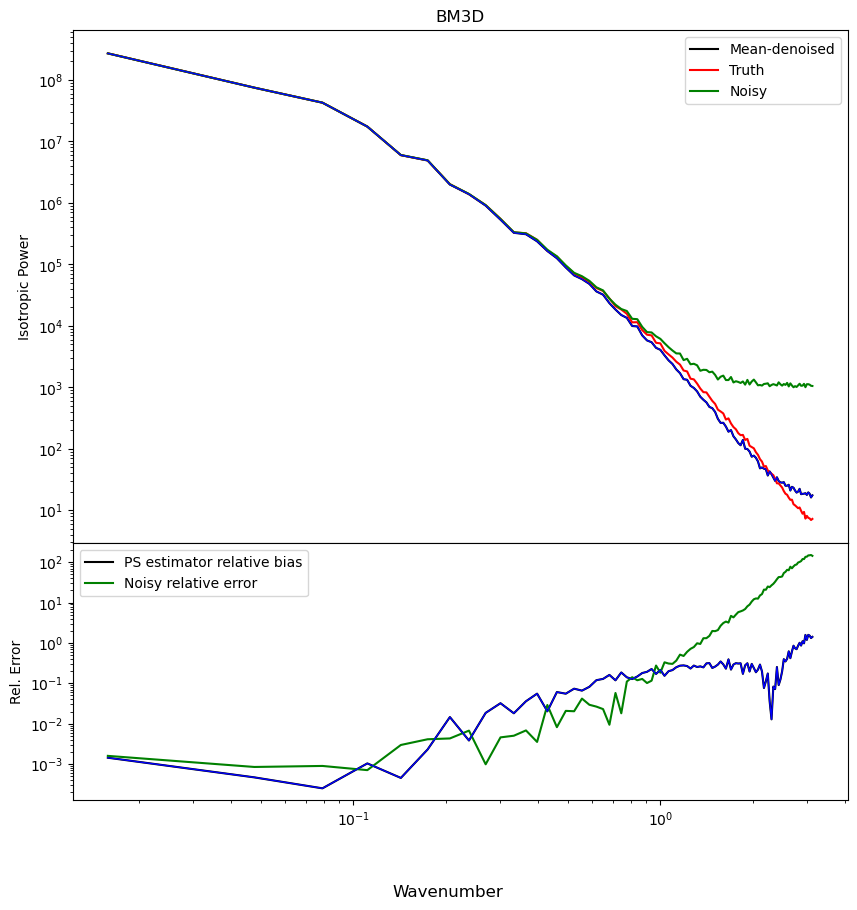

In [86]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth,torch.from_numpy(denoised_bm3d.reshape(1,1,256,256)), noisy = observation, only_trajectories= True, title = 'BM3D', elementary_figsize=(10,10), relative_error= True)

### Verify that MMSE estimator is mean of the conditional distribution after denoising

In [21]:
noisy_list, denoised_list = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=NUM_MAX_SAMPLES, tweedie=False, rescale_observation=True)

100%|██████████| 200/200 [00:08<00:00, 22.36it/s]


In [22]:
noisy_list2, denoised_list2 = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)

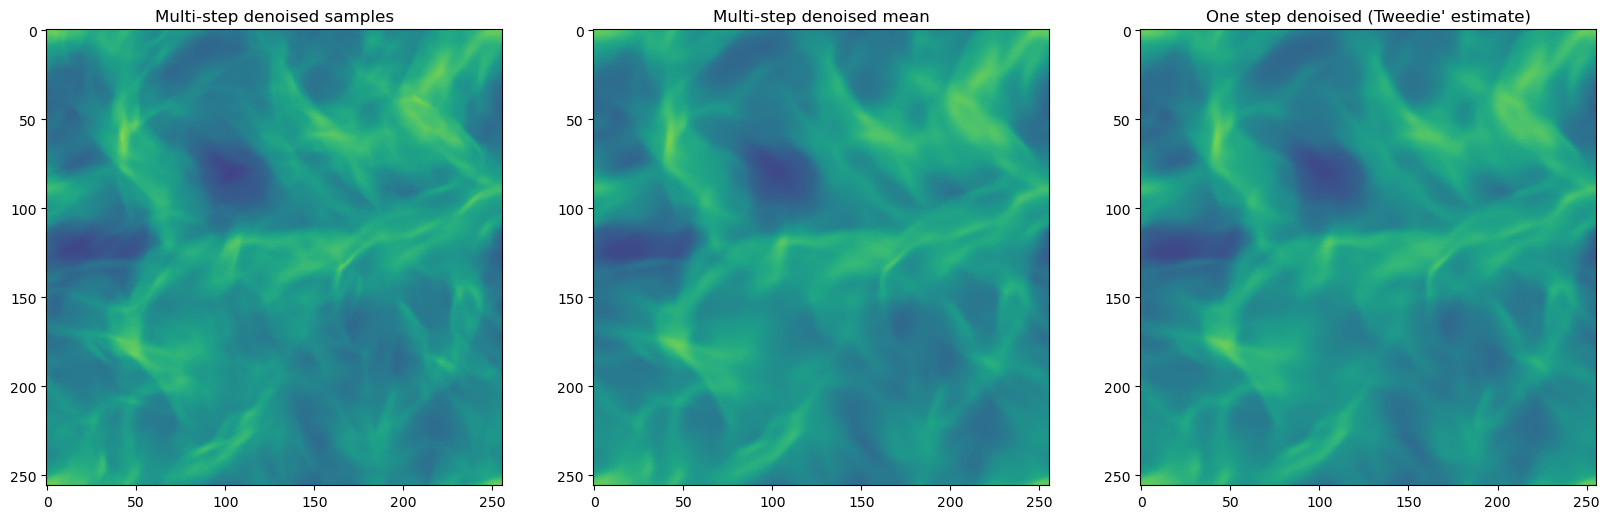

In [23]:
### MODIFIED COLOR BAR TO SEE MORE DETAILS
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[0].title.set_text('Multi-step denoised samples')
ax[1].imshow(denoised_list[0].mean(dim=0)[0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[1].title.set_text('Multi-step denoised mean')
ax[2].imshow(denoised_list2[0][0][0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[2].title.set_text("One step denoised (Tweedie' estimate)")

In [24]:
print("L2 distance (squared) between Tweedie's estimate and average of multistep denoising : "+str(F.mse_loss(denoised_list2[0][0][0], denoised_list[0].mean(dim=0)[0]).detach().cpu().item()))
print("MSE between the multistep denoising distribution and Tweedie's estimate : "+str(F.mse_loss(denoised_list2[0][:1].repeat(NUM_MAX_SAMPLES,1 ,1, 1), denoised_list[0][:]).detach().cpu().item()))

L2 distance (squared) between Tweedie's estimate and average of multistep denoising : 0.0003204993554390967
MSE between the multistep denoising distribution and Tweedie's estimate : 0.01549550797790289


#### PSNR Computation

In [59]:
times = range(0, diffuser.diffmodel.sde.N, 100)
noise_level = diffuser.diffmodel.sde.noise_level(times)

max2_I = truth.square().max()

noisy_psnr_list = []
denoised_psnr_list = []
denoised_tweedies_psnr_list = []

noisy_snr_list = []
denoised_snr_list = []
denoised_tweedies_snr_list = []

for t in times:
    noise=torch.randn_like(truth)
    timesteps=torch.full((truth.shape[0],), t).long().to(device)

    observation , _, _ = diffuser.diffmodel.sde.sampling(truth, t)
    observation = diffuser.diffmodel.sde.rescale_preserved_to_additive(observation, t)

    _ , denoised_list = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=NUM_SAMPLES, tweedie=False, rescale_observation=True)
    _ , denoised_list2 = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)
    
    PSNR_noisy = 10 * torch.log10(max2_I/F.mse_loss(observation,truth))
    PSNR_denoised = 10 * torch.log10(max2_I/F.mse_loss(denoised_list[0],truth.repeat(NUM_SAMPLES, 1, 1, 1)))
    PSNR_tweedie = 10 * torch.log10(max2_I/F.mse_loss(denoised_list2[0], truth))

    noisy_psnr_list.append(PSNR_noisy.detach().cpu().item())
    denoised_psnr_list.append(PSNR_denoised.detach().cpu().item())
    denoised_tweedies_psnr_list.append(PSNR_tweedie.detach().cpu().item())
    

0it [00:00, ?it/s]
100%|██████████| 900/900 [00:20<00:00, 44.22it/s]


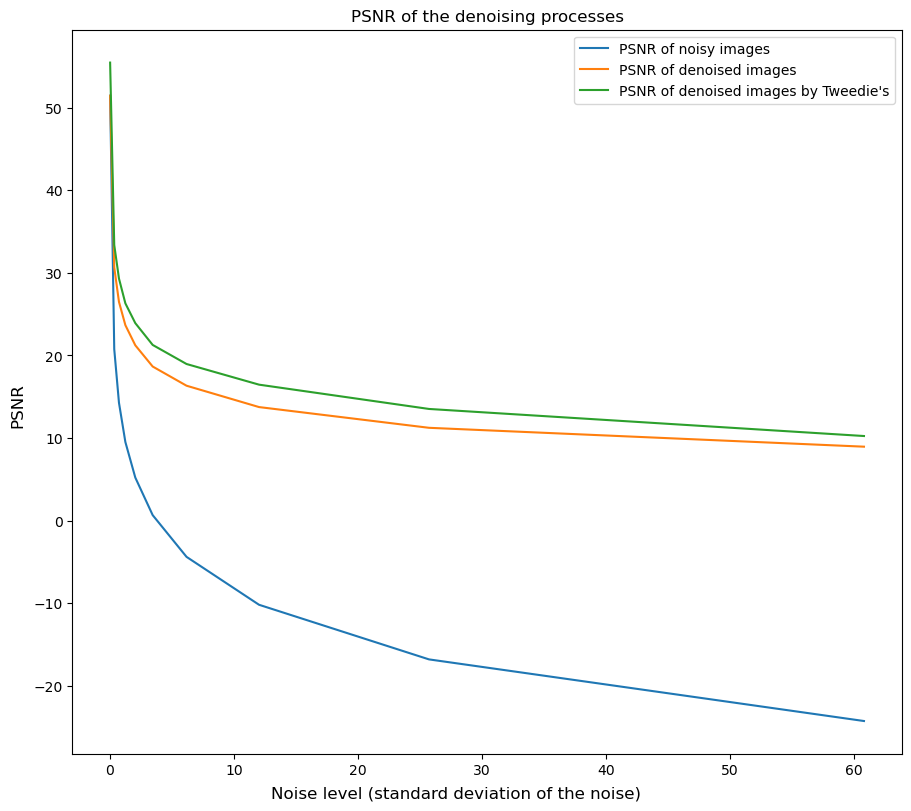

In [61]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
noises = noise_level.detach().cpu().reshape(-1)
ax.plot(noises, noisy_psnr_list, label = 'PSNR of noisy images')
ax.plot(noises, denoised_psnr_list, label = 'PSNR of denoised images')
ax.plot(noises, denoised_tweedies_psnr_list, label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

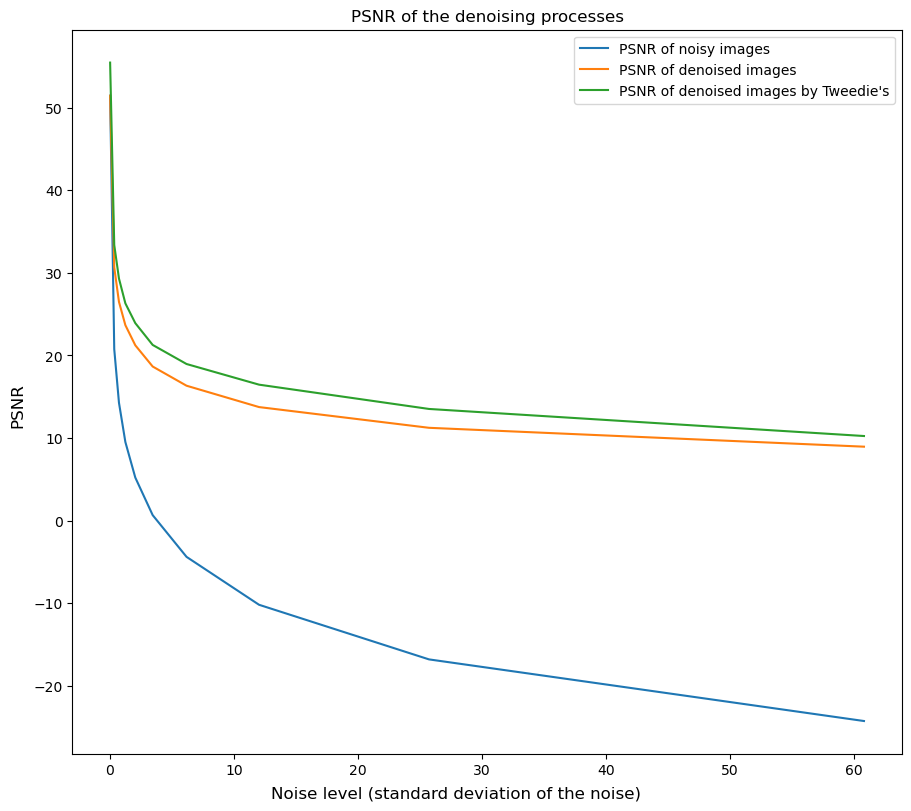

In [62]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(noises[:10], noisy_psnr_list[:10], label = 'PSNR of noisy images')
ax.plot(noises[:10], denoised_psnr_list[:10], label = 'PSNR of denoised images')
ax.plot(noises[:10], denoised_tweedies_psnr_list[:10], label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

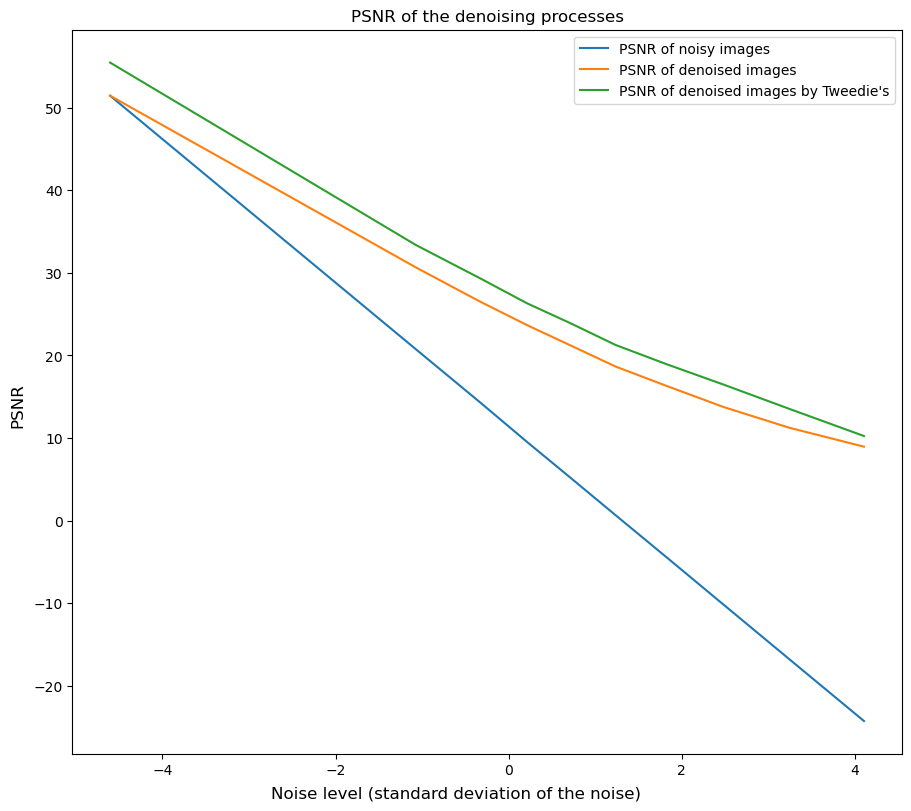

In [63]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(torch.log(noises), noisy_psnr_list, label = 'PSNR of noisy images')
ax.plot(torch.log(noises), denoised_psnr_list, label = 'PSNR of denoised images')
ax.plot(torch.log(noises), denoised_tweedies_psnr_list, label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

### Power Spectrum estimator error for Score Based Models and BM3D

In [ ]:
times = range(200, 2800, 400)
noise_level = diffuser.diffmodel.sde.noise_level(times).reshape(-1)
bins = torch.linspace(0, np.pi, 100)

## Play with these parameters
num_samples = 8
batch_size = 20
test_dataloader = DataLoader(diffuser.test_dataloader.dataset, batch_size=batch_size, shuffle=False, num_workers=8)

signed_relative_error = torch.zeros((len(times), len(bins)-1))

for i, time in enumerate(times):
    with torch.no_grad():
        M = len(test_dataloader.dataset)
        n = len(test_dataloader)
        progress_bar = tqdm(total=n)
        progress_bar.set_description(f"Noise level n° {i}")
        for _, testbatch in enumerate(test_dataloader):
            testbatch = testbatch.to(device).unsqueeze(1)
            timesteps=torch.full((testbatch.shape[0],), time).long().to(device)

            observation , _, _ = diffuser.diffmodel.sde.sampling(testbatch, timesteps)

            observation = diffuser.diffmodel.sde.rescale_preserved_to_additive(observation, timesteps)

            _ , denoised_list = separation1score(diffuser, observation, noise_step=time, NUM_SAMPLES=num_samples, tweedie=False, rescale_observation=True, verbose = False)
            #_ , denoised_list2 = separation1score(diffuser, observation, noise_step=time, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)
            denoised_list = torch.cat(denoised_list, dim=0)
            #denoised_list2 = torch.cat(denoised_list2, dim=0)
            power_spectra, _, _, _ = powerspectrum.set_power_spectrum_iso2d(denoised_list, bins = bins, only_stat = False, use_gpu=False)
            power_spectra_true, _, _, _ = powerspectrum.set_power_spectrum_iso2d(testbatch, bins = bins, only_stat = False, use_gpu=False)
            power_spectra = torch.split(power_spectra, num_samples, dim=0)
            power_spectra = torch.cat([ps.mean(dim=0, keepdim=True) for ps in power_spectra], dim=0)
            signed_relative_error[i] += ((power_spectra - power_spectra_true) / power_spectra_true).sum(dim=0)[:-1]
            progress_bar.update(1)
        progress_bar.close()
        signed_relative_error[i] /= M


In [ ]:
# Assuming you have your data in the form of 2D array


noise_level100 = np.interp(np.linspace(200, 2600, 100), times, noise_level.cpu())
fig, ax = plt.subplots()

# create an "invisible" scatter plot just for the logarithmic x-axis
ax.scatter(np.logspace(0, np.pi, 100), noise_level100, s = 0)  # s=0 makes points invisible
ax.set_xscale('log')
ax.set_ylabel('Noise level')
ax.set_xlabel('Wave number')

# create the actual heatmap
img = ax.imshow(signed_relative_error, aspect='auto', origin='lower', extent=[0, np.pi, 0.2, 9], vmin = -1, vmax = 1, cmap = 'bwr')

fig.colorbar(img, ax=ax, label='Goodness of Algorithm')

plt.show()


In [ ]:
## Play with these parameters
num_samples = 1
batch_size = 20
test_dataloader = DataLoader(diffuser.test_dataloader.dataset, batch_size=batch_size, shuffle=False, num_workers=8)

signed_relative_error_bm3d = torch.zeros((len(times), len(bins)-1))

noise_level = noise_level.cpu()
for i, time in enumerate(times[1:]):
    with torch.no_grad():
        M = len(test_dataloader.dataset)
        progress_bar = tqdm(total=M)
        progress_bar.set_description(f"Noise level n° {i}")
        for level, testimg in enumerate(test_dataloader.dataset):
            testbatch = testimg.unsqueeze(0).unsqueeze(0).to(device)
            _, ps_true, _ = powerspectrum.power_spectrum_iso2d(testbatch, bins = bins, use_gpu=True)
            for _ in range(num_samples):
                observation , _, _ = diffuser.diffmodel.sde.sampling(testbatch, timesteps)
                observation = diffuser.diffmodel.sde.rescale_preserved_to_additive(observation, timesteps)

                img = observation[0][0].cpu().numpy()
                denoised_bm3d = bm3d(img, sigma_psd = noise_level[i+1], stage_arg=BM3DStages.HARD_THRESHOLDING,)

                denoised_bm3d = torch.from_numpy(denoised_bm3d).unsqueeze(0).unsqueeze(0).to(device)

                _, ps_denoised, _ = powerspectrum.power_spectrum_iso2d(denoised_bm3d, bins = bins, use_gpu=True)

                signed_relative_error_bm3d[i+1] += ((ps_denoised.reshape(-1) - ps_true.reshape(-1)) / ps_true.reshape(-1))[:-1].cpu()
                progress_bar.update(1)
        signed_relative_error_bm3d[i+1] /= (M * num_samples)
        progress_bar.close()


In [ ]:
# Assuming you have your data in the form of 2D array 

noise_level100 = np.interp(np.linspace(200, 2600, 100), times, noise_level.cpu())
fig, ax = plt.subplots()

# create an "invisible" scatter plot just for the logarithmic x-axis
ax.scatter(np.logspace(0, np.pi, 100), noise_level100, s = 0)  # s=0 makes points invisible
ax.set_xscale('log')
ax.set_ylabel('Noise level')
ax.set_xlabel('Wave number')

# create the actual heatmap
img = ax.imshow(signed_relative_error_bm3d, aspect='auto', origin='lower', extent=[0, np.pi, 0.2, 9], vmin = -1, vmax = 1, cmap = 'bwr')

fig.colorbar(img, ax=ax, label='Goodness of Algorithm')

plt.show()

# WORK IN PROGRESS

### Multi-score methods

Source separations methods here take two models as inputs.

In [ ]:
observation = testbatch1[0]+testbatch2[0]
observation = observation.unsqueeze(0)

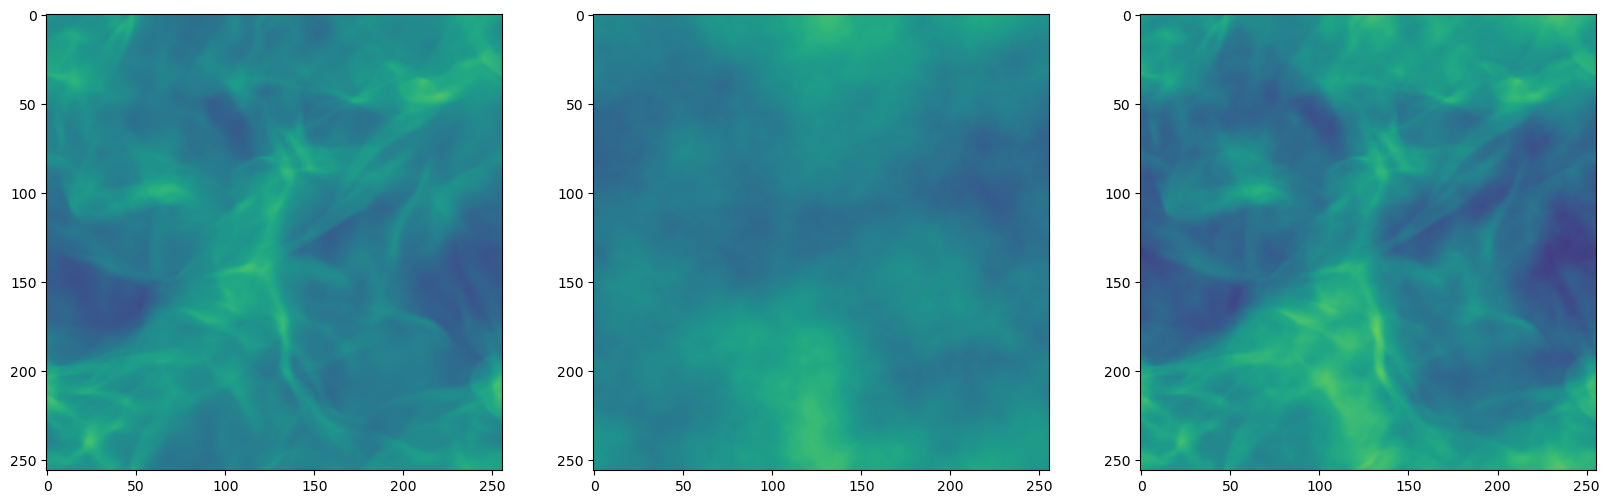

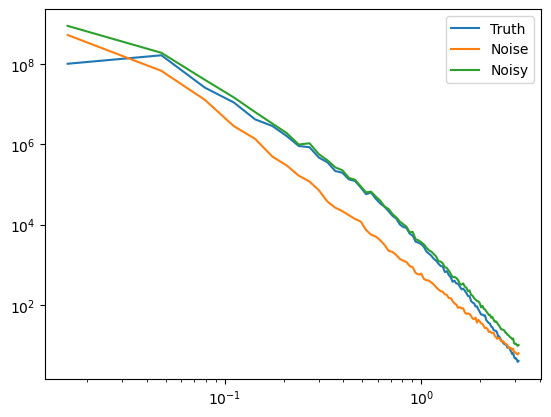

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(testbatch1[0][0],vmin=amin, vmax=amax)
ax[1].imshow(testbatch2[0][0],vmin=amin, vmax=amax)
ax[2].imshow(observation[0][0],vmin=amin, vmax=amax)
plt.show()
_, b1, _ = power_spectrum_iso(testbatch1[0][0],bins=bins)
_, b2, _ = power_spectrum_iso(testbatch2[0][0],bins=bins)
_, b3, _ = power_spectrum_iso(observation[0][0].cpu(),bins=bins)
plot_ps(bins, [b1, b2, b3], ['Truth', 'Noise', 'Noisy'], show = True)

In [ ]:
sample, observation = method1_algo2(model1, model2, observation, NUM_SAMPLES=16)

100%|██████████| 2000/2000 [01:16<00:00, 26.27it/s]


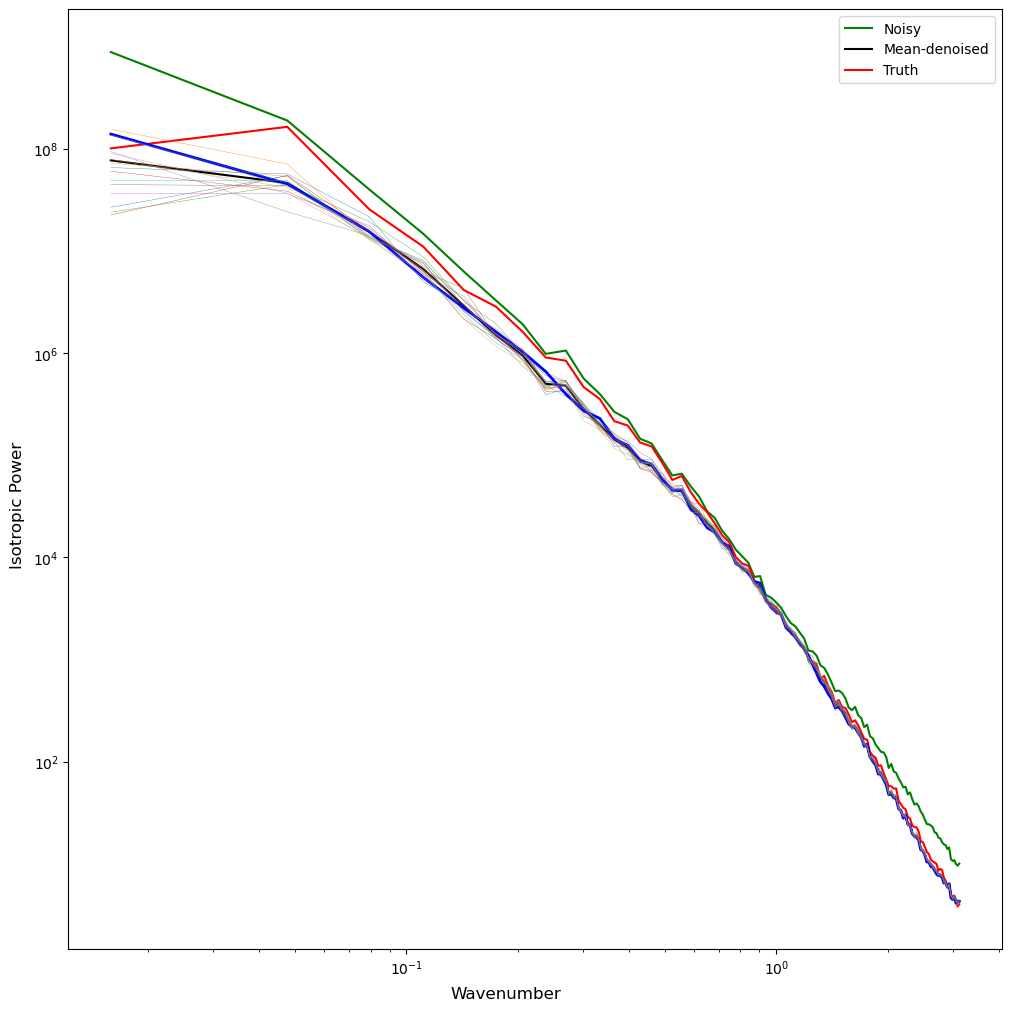

In [ ]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(testbatch1[0].unsqueeze(0),sample, noisy = observation, only_trajectories= True)

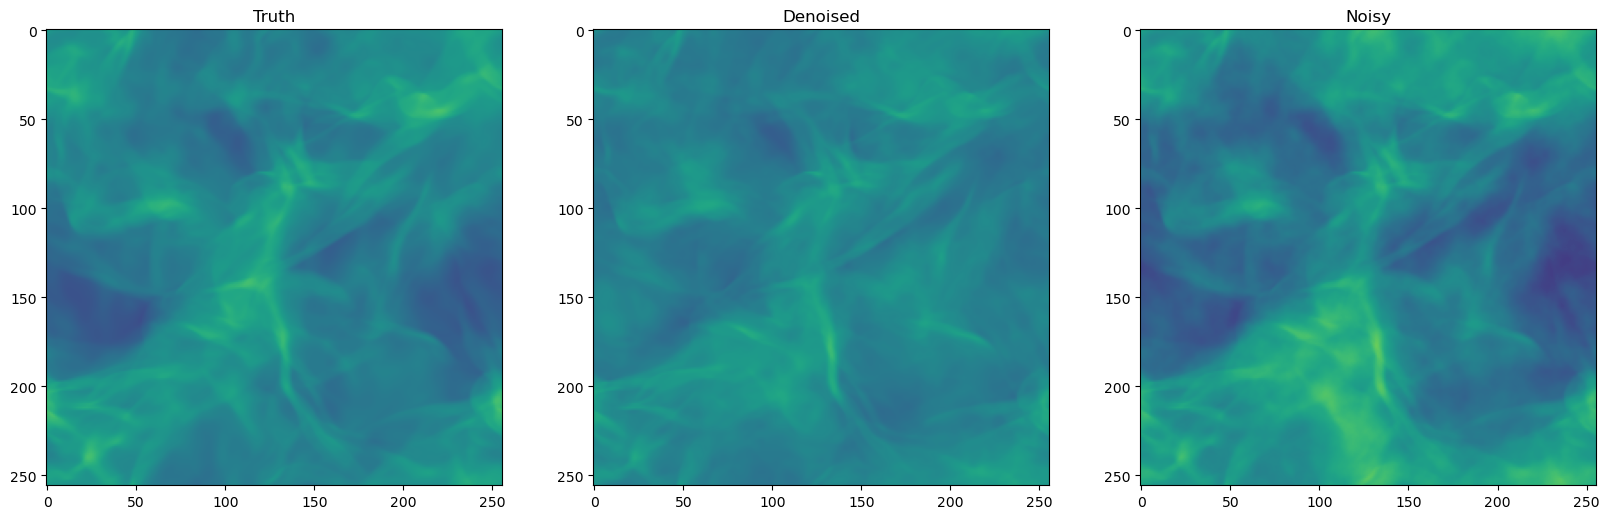

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(testbatch1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(sample[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised')
ax[2].imshow(observation[0][0],vmin=amin, vmax=amax)
ax[2].title.set_text('Noisy')


In [10]:
save_path = '/mnt/home/dheurtel/astroddpm/comparison/DiscreteSBM_VPSDE_MHD_BPROJ_N_4000_bottleneck_32'

In [12]:
os.path.isdir(save_path)

False